# State Space Model with Dynamic Coefficient $\alpha_t$ for Exponential Smoothing
**Coding Example**

In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Simulated data (replace with your own data)
n = 100  # Number of observations
true_alpha = 0.2  # True alpha value to generate data
x = np.zeros(n)
y = np.zeros(n)
e = np.random.normal(0, 2, n)  # Observation error
x[0] = np.random.normal(0, 1)  # Initial state

# Generate simulated data
for t in range(1, n):
    x[t] = x[t-1] + true_alpha * e[t]
    y[t] = x[t-1] + e[t]

In [3]:
with pm.Model() as model:
    # Define priors for unknown parameters.
    # Use a Beta distribution for alpha, with hyperparameters you 
    # can adjust as needed.
    
    # Dynamic coefficient alpha between 0 and 1
    alpha = pm.Beta('alpha', alpha=1, beta=1, shape=n)
    
    # Standard deviation of observation error
    sigma_e = pm.HalfNormal('sigma_e', sigma=1)  

    # Define the state space model
    
    # Initial state
    x_prior = pm.Normal('x_0', mu=0, sigma=2)  
    x_obs = pm.Normal('x_obs', mu=x_prior + alpha[:-1] * e[1:], sigma=sigma_e, observed=y[1:] - e[1:])

    # Sampling
    print("Starting sampling...")
    trace = pm.sample(
        1_000, 
        return_inferencedata=True, 
        progressbar=True
    )
    print("Sampling completed.")

# Results analysis
print(pm.summary(trace))

Starting sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma_e, x_0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Sampling completed.
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x_0       -1.145  0.143  -1.408   -0.866      0.002    0.001    5131.0   
alpha[0]   0.528  0.277   0.084    0.999      0.004    0.003    4530.0   
alpha[1]   0.375  0.268   0.000    0.866      0.004    0.003    5349.0   
alpha[2]   0.457  0.289   0.003    0.927      0.004    0.003    5471.0   
alpha[3]   0.267  0.213   0.000    0.663      0.003    0.003    4579.0   
...          ...    ...     ...      ...        ...      ...       ...   
alpha[96]  0.554  0.278   0.086    0.996      0.004    0.003    4947.0   
alpha[97]  0.373  0.269   0.000    0.866      0.004    0.003    4424.0   
alpha[98]  0.553  0.285   0.074    0.998      0.004    0.003    5363.0   
alpha[99]  0.499  0.292   0.042    0.986      0.004    0.003    5452.0   
sigma_e    1.312  0.109   1.114    1.516      0.002    0.001    4019.0   

           ess_tail  r_hat  
x_0          2902.0    1.0  
alpha[0]     1969.0    1.0  
alph

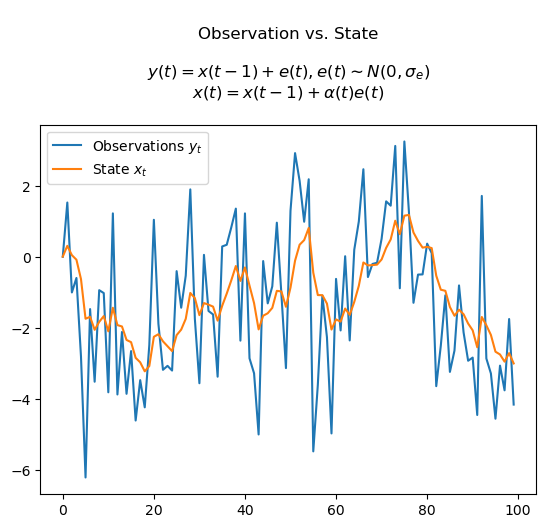

In [4]:
# Plot observations vs state
plt.plot(y, label='Observations $y_t$')
plt.plot(x, label='State $x_t$')
tmp = f"""
Observation vs. State

$y(t) = x(t-1) + e(t), e(t) \sim N(0, \sigma_e)$
$x(t) = x(t-1) + \\alpha(t) e(t)$
"""
plt.title(tmp)
plt.legend()

In [5]:
# Calculate mean alpha, observation error, and mean sigma_e
alpha_mean = trace.posterior['alpha'].values.mean(axis=(0,1))

error = y - x

sigma_e_samples = trace.posterior["sigma_e"].values

sigma_e_mean = sigma_e_samples.mean(axis=(0, 1))

sigma_error = (1 - alpha_mean) * sigma_e_mean

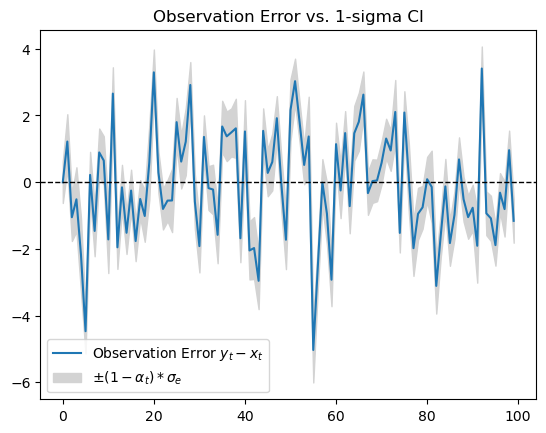

In [6]:
# Plot observation error with 1-sigma confidence bands
plt.plot(error, label='Observation Error $y_t - x_t$')
s_factor = 1
plt.fill_between(
    np.arange(n), 
    error - s_factor * sigma_error, error + s_factor * sigma_error,
    color='lightgray',
    label='$\\pm (1 - \\alpha_t)*\sigma_e$'
)
plt.legend()
plt.title('Observation Error vs. 1-sigma CI')
plt.axhline(0, color='black', lw=1, linestyle='--')

Text(0.5, 1.0, 'Estimated $\\alpha_t$ over time')

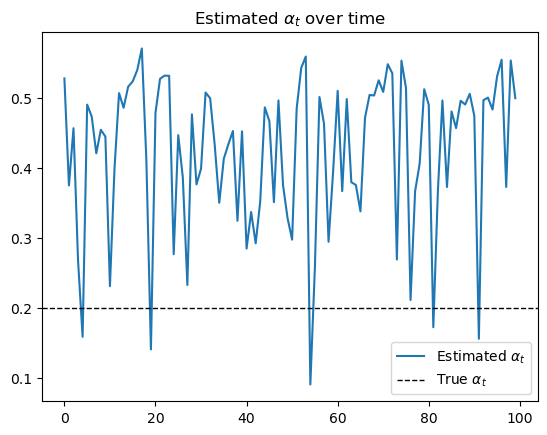

In [7]:
# Plot estimated alpha over time
plt.plot(alpha_mean, label='Estimated $\\alpha_t$')
plt.axhline(
    true_alpha,
    color='black',
    lw=1,
    linestyle='--',
    label='True $\\alpha_t$'
)
plt.legend()
plt.title('Estimated $\\alpha_t$ over time')